In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import iglob

# Import and proprocess data

In [2]:
def conversion_iter(x, num_cells):
    if num_cells=='10k':
        return [10000*y for y in x]
    elif num_cells=='100k':
        return [100000*y for y in x]
    elif num_cells=='500k':
        return [500000*y for y in x]
    elif num_cells=='1M':
        return [1000000*y for y in x]
    return x

conversion_obs = {'10k': 10000, '100k': 100000, '500k': 500000, '1M': 1000000}
conversion_model_layer = {'2/1024': 2, '2/4096': 2, '2/2048': 2, '1/2048': 1, '1/4096': 1, '2/8192': 2, '1/8192': 1}
conversion_model_hidden = {'1/2048': 2048, '1/4096': 4096, '2/1024': 1024, '2/2048': 2048, '2/4096': 4096, '2/8192': 8192, '1/8192': 8192}

In [3]:
genes = ['2k', '10k', 'all']
model = ['2/1024', '2/4096', '2/2048', '2/8192', '1/2048', '1/4096', '1/8192']
data_names = ['elbo', 'reconstr_loss', 'loss', 'metrics']

empty_data = []
not_existent = []
empty_folder = []
data = []
for d in data_names:
    metric_data = []
    for g in genes:
        for m in model:
            if d=='metrics':
                csv =[]
                for path in iglob(f'1M/{g}_genes/{m}/metrics/metrics_*.csv'):
                    try:
                        csv.append(pd.read_csv(path))
                    except pd.errors.EmptyDataError:
                        empty_data.append(path)
                    except FileNotFoundError:
                        not_existent.append(path)
                try:
                    csv = pd.concat(csv)
                except ValueError:
                    empty_folder.append(f'1M/{g}_genes/{m}')
                    csv = pd.DataFrame(columns = ['', 'n_obs', 'n_cells', 'n_genes', 'n_layers', 'n_hidden', 'metric', 'value'])
            else:
                try:
                    path = f'1M/{g}_genes/{m}/metrics/{d}.csv'
                    csv = pd.read_csv(path)
                    csv['iteration']=conversion_iter(csv['Unnamed: 0'], '1M')
                    csv['genes'] = g
                    csv['cells'] = '1M'
                    csv['layers'] = conversion_model_layer[m]
                    csv['hidden'] = conversion_model_hidden[m]
                    csv['n_obs'] = 1000000
                except FileNotFoundError:
                        not_existent.append(path)
            metric_data.append(csv)
                
    data.append(pd.concat(metric_data))

In [4]:
not_existent


['1M/2k_genes/1/4096/metrics/elbo.csv',
 '1M/10k_genes/1/8192/metrics/elbo.csv',
 '1M/all_genes/2/4096/metrics/elbo.csv',
 '1M/all_genes/1/8192/metrics/elbo.csv',
 '1M/2k_genes/1/4096/metrics/reconstr_loss.csv',
 '1M/10k_genes/1/8192/metrics/reconstr_loss.csv',
 '1M/all_genes/2/4096/metrics/reconstr_loss.csv',
 '1M/all_genes/1/8192/metrics/reconstr_loss.csv',
 '1M/2k_genes/1/4096/metrics/loss.csv',
 '1M/10k_genes/1/8192/metrics/loss.csv',
 '1M/all_genes/2/4096/metrics/loss.csv',
 '1M/all_genes/1/8192/metrics/loss.csv']

In [5]:
elbo = data[0].rename(columns={'Unnamed: 0': 'epoch', 'train_elbo': 'train_elbo', 'val_elbo': 'val_elbo', 'genes': 'genes', 'cells': 'cells', 'layers': 'layers', 'hidden': 'hidden', 'iteration': 'iteration'})
scib = data[3]
recon = data[1].rename(columns={'Unnamed: 0': 'epoch', 'train_recon_loss': 'train_recon_loss', 'val_recon_loss': 'val_recon_loss', 'genes': 'genes', 'cells': 'cells', 'layers': 'layers', 'hidden': 'hidden', 'iteration': 'iteration'})
loss = data[2].rename(columns={'Unnamed: 0': 'epoch', 'train_loss': 'train_loss', 'val_loss': 'val_loss', 'genes': 'genes', 'cells': 'cells', 'layers': 'layers', 'hidden': 'hidden', 'iteration': 'iteration'})

In [6]:
elbo = pd.melt(elbo, id_vars=['epoch', 'genes', 'cells', 'iteration', 'layers', 'hidden'], value_vars=['train_elbo', 'val_elbo'], value_name='elbo', var_name='cat')
recon = pd.melt(recon, id_vars=['epoch', 'genes', 'cells', 'iteration', 'layers', 'hidden'], value_vars=['train_recon_loss', 'val_recon_loss'], value_name='recon_loss', var_name='cat')
loss = pd.melt(loss, id_vars=['epoch', 'genes', 'cells', 'iteration', 'layers', 'hidden'], value_vars=['train_loss', 'val_loss'], value_name='loss', var_name='cat')

In [7]:
scib_tmp =  scib[['n_genes', 'n_layers', 'n_hidden']]
scib_tmp.drop_duplicates()

,n_genes,n_layers,n_hidden
0,2k_genes,2,1024
0,2k_genes,2,4096
0,2k_genes,2,2048
0,2k_genes,2,8192
0,2k_genes,1,2048
0,2k_genes,1,4096
0,2k_genes,1,8192
0,10k_genes,2,1024
0,10k_genes,2,4096
0,10k_genes,2,2048


# ELBO

In [8]:
elbo['key_data'] = elbo['cells'].astype(str)+'_'+elbo['genes'].astype(str)
elbo['key_nn'] = elbo['layers'].astype(str)+'_'+elbo['hidden'].astype(str) 

In [9]:
elbo[elbo['layers']==2]

,epoch,genes,cells,iteration,layers,hidden,cat,elbo,key_data,key_nn
0,0,2k,1M,0,2,1024,train_elbo,1166.327026,1M_2k,2_1024
1,1,2k,1M,1000000,2,1024,train_elbo,951.052917,1M_2k,2_1024
2,2,2k,1M,2000000,2,1024,train_elbo,819.774963,1M_2k,2_1024
3,3,2k,1M,3000000,2,1024,train_elbo,784.018616,1M_2k,2_1024
4,4,2k,1M,4000000,2,1024,train_elbo,768.286438,1M_2k,2_1024
...,...,...,...,...,...,...,...,...,...,...
16603,47,all,1M,47000000,2,8192,val_elbo,5012.805176,1M_all,2_8192
16604,48,all,1M,48000000,2,8192,val_elbo,5012.422363,1M_all,2_8192
16605,49,all,1M,49000000,2,8192,val_elbo,5013.333008,1M_all,2_8192
16606,50,all,1M,50000000,2,8192,val_elbo,5013.664062,1M_all,2_8192


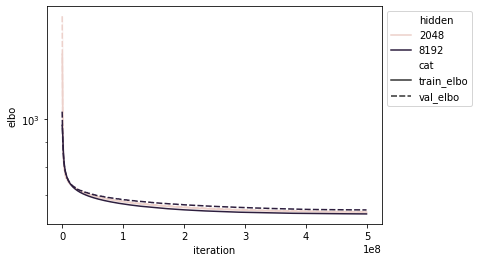

In [10]:
tmp = elbo[elbo['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

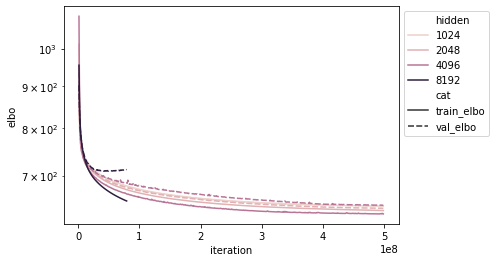

In [11]:
tmp = elbo[elbo['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

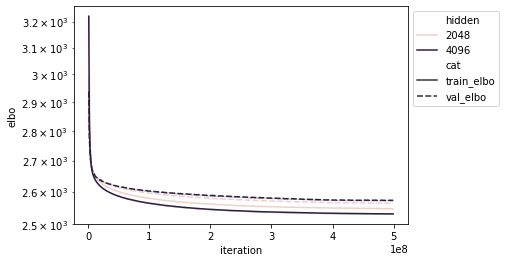

In [12]:
tmp = elbo[elbo['layers']==1]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

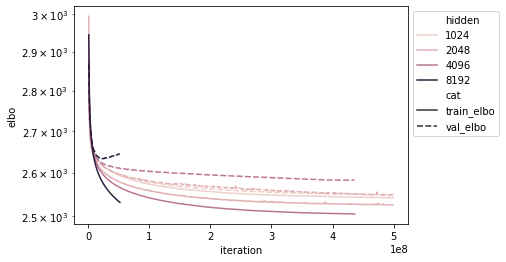

In [13]:
tmp = elbo[elbo['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

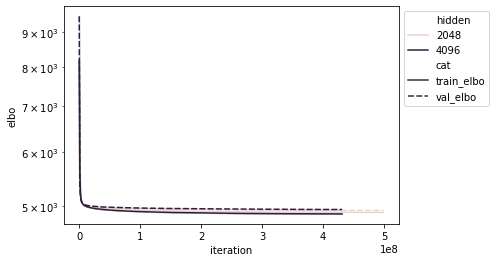

In [14]:
tmp = elbo[elbo['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

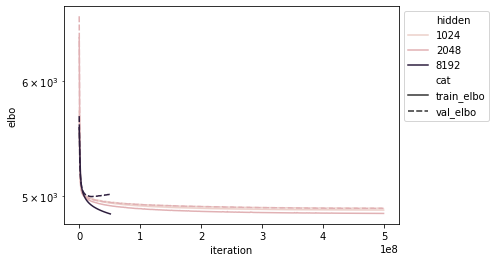

In [15]:
tmp = elbo[elbo['layers']==2]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='elbo', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

# Reconstruction Loss

In [16]:
recon['key_data'] = recon['cells']+'_'+recon['genes']

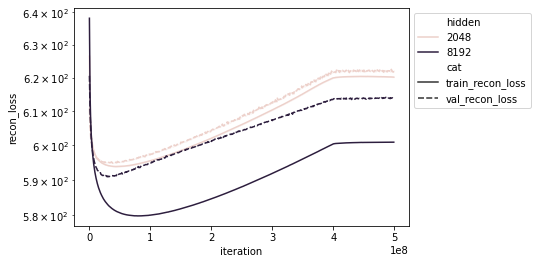

In [17]:
tmp = recon[recon['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

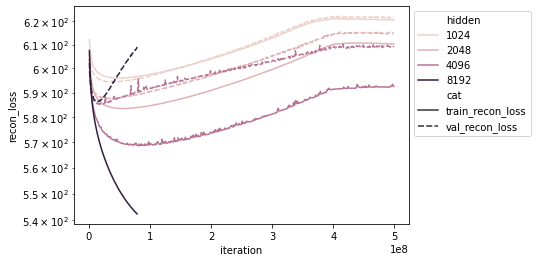

In [18]:
tmp = recon[recon['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

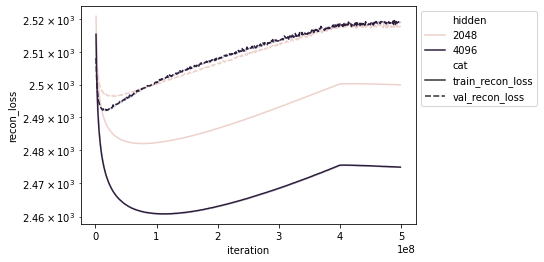

In [19]:
tmp = recon[recon['layers']==1]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

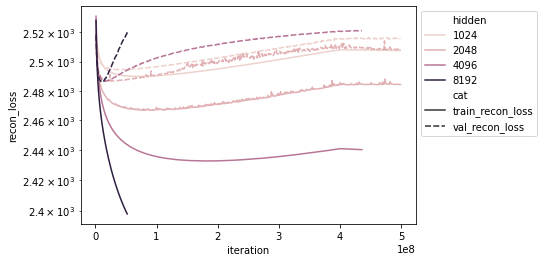

In [20]:
tmp = recon[recon['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

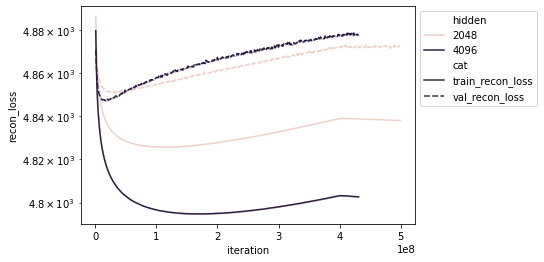

In [21]:
tmp = recon[recon['layers']==1]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

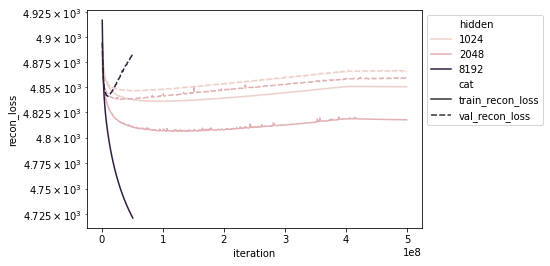

In [22]:
tmp = recon[recon['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='recon_loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

# Loss

In [23]:
loss['key_data'] = loss['cells'].astype(str)+'_'+loss['genes'].astype(str)
loss['key_nn'] = loss['layers'].astype(str)+'_'+loss['hidden'].astype(str)

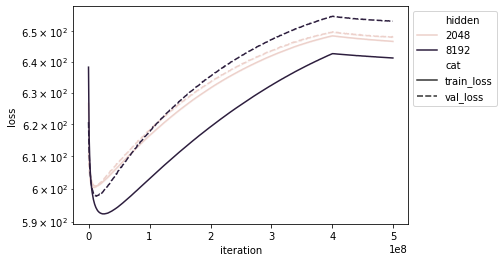

In [24]:
tmp = loss[loss['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

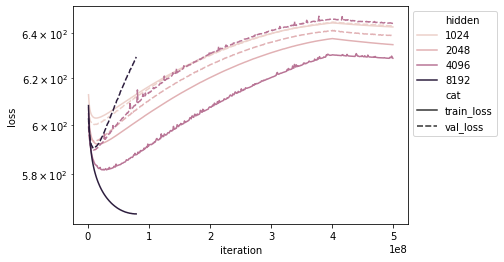

In [25]:
tmp = loss[loss['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_2k'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

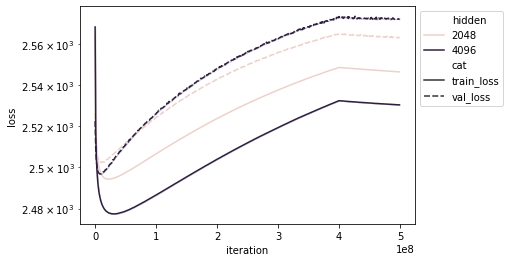

In [26]:
tmp = loss[loss['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

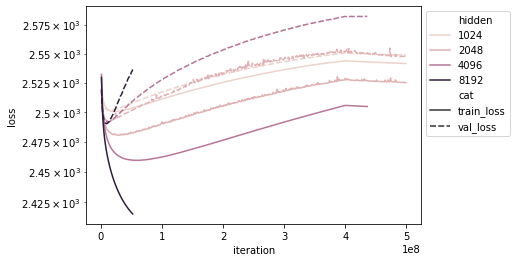

In [27]:
tmp = loss[loss['layers']==2]
tmp = tmp[tmp['iteration']!=0]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_10k'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

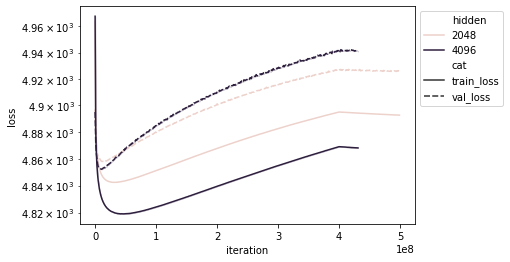

In [28]:
tmp = loss[loss['layers']==1]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

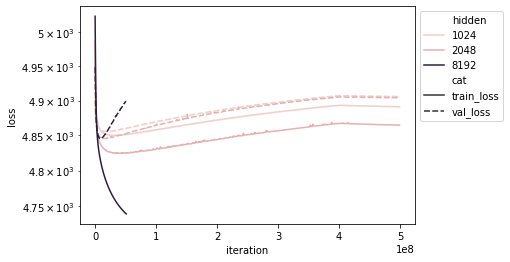

In [29]:
tmp = loss[loss['layers']==2]
fig = sns.lineplot(tmp[tmp['key_data']=='1M_all'], x='iteration', y='loss', hue='hidden', style='cat')
fig.set(yscale='log')
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

# Metrics

## HGV Overlap

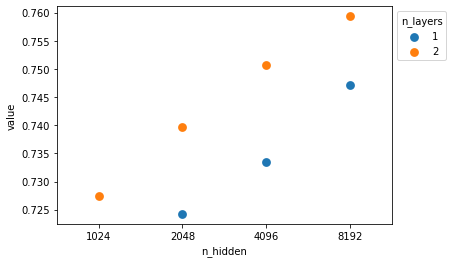

In [30]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

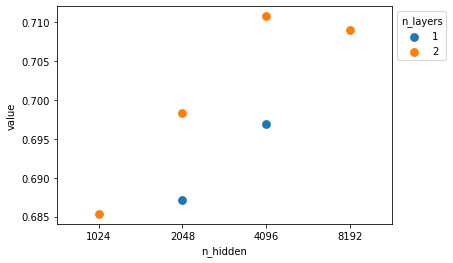

In [31]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

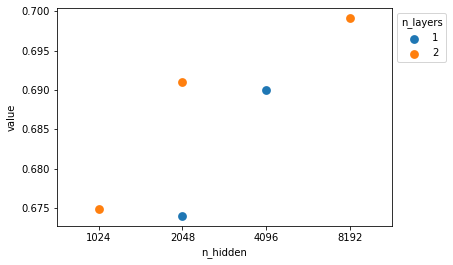

In [32]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

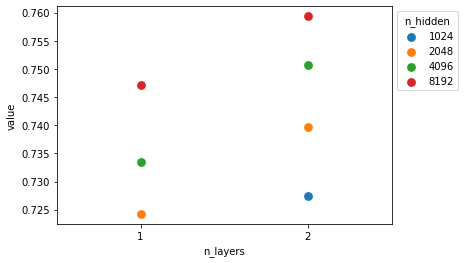

In [33]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

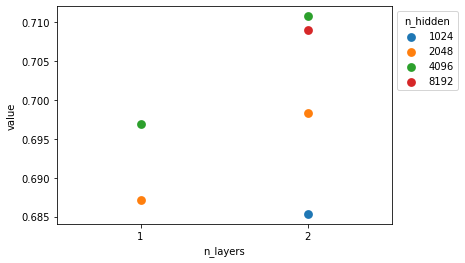

In [34]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

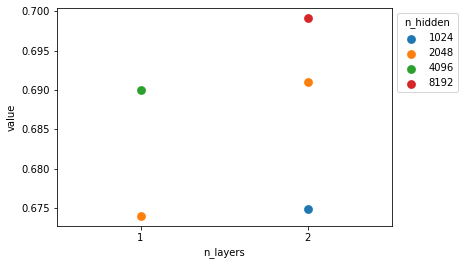

In [35]:
tmp = scib[scib['metric']=='hgv_overlap']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Trajectory conservation

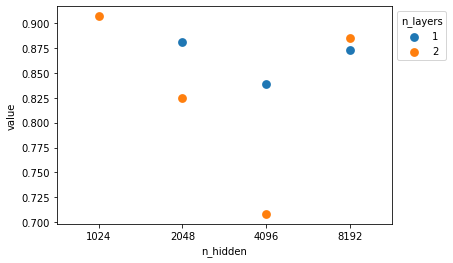

In [36]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

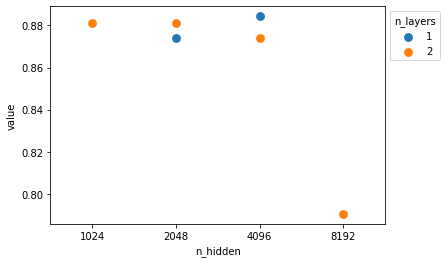

In [37]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

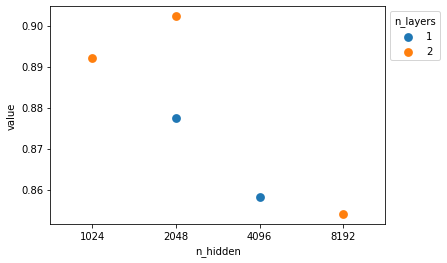

In [38]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='n_layers', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

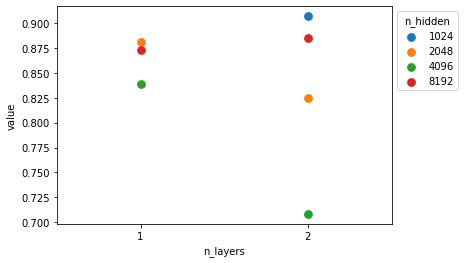

In [39]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

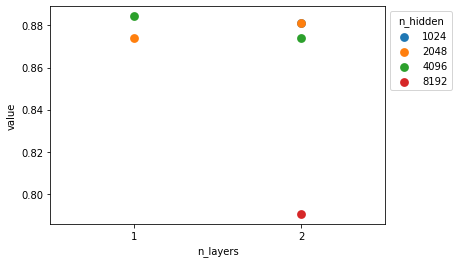

In [40]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

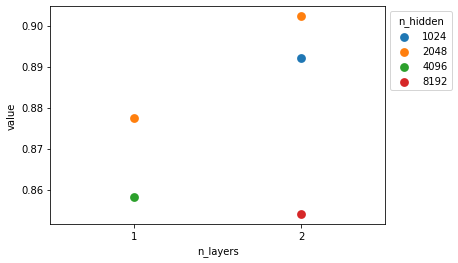

In [41]:
tmp = scib[scib['metric']=='traject_conservation']
tmp = tmp[tmp['n_cells']=='1M']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='n_hidden', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Principle Component Regession

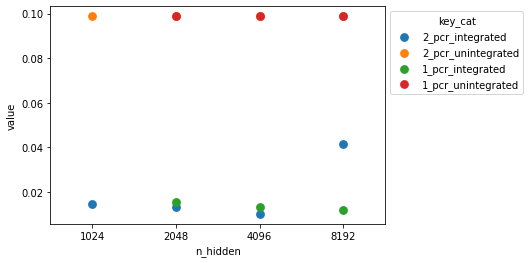

In [42]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

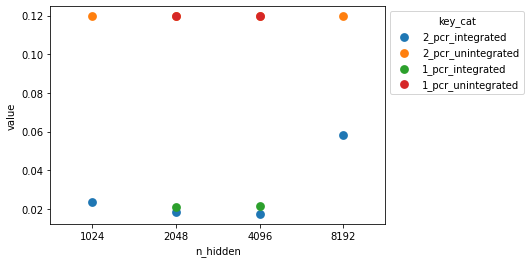

In [43]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

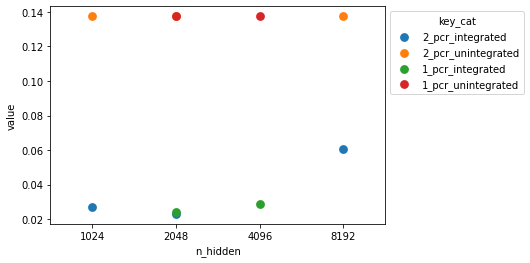

In [44]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

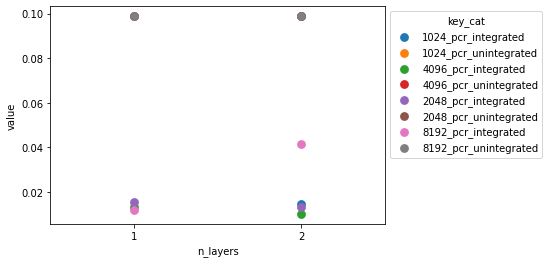

In [45]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

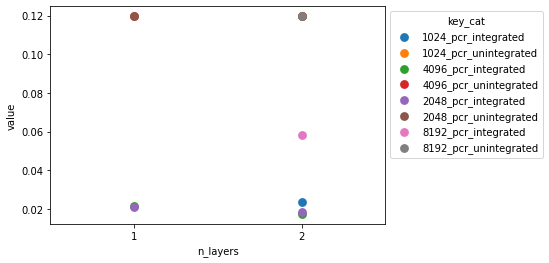

In [46]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

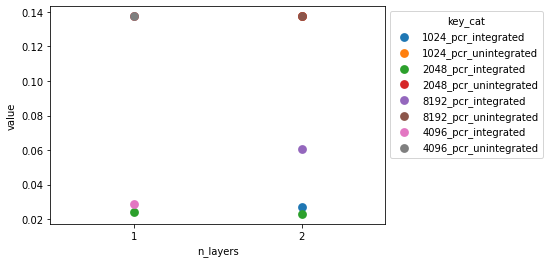

In [47]:
tmp = scib[[x in ['pcr_integrated', 'pcr_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Graph connectivity

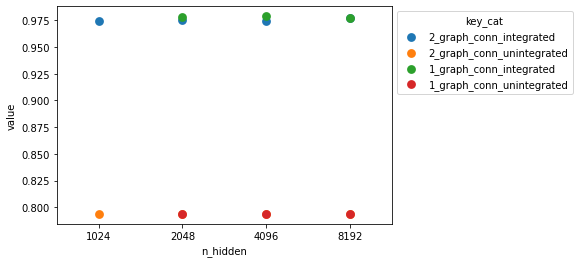

In [48]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

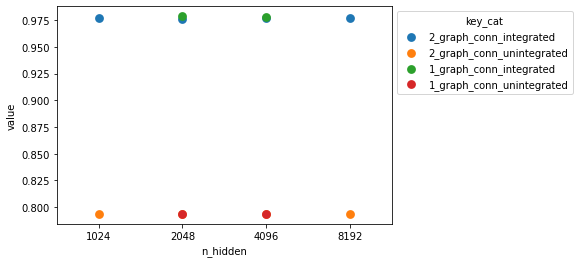

In [49]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

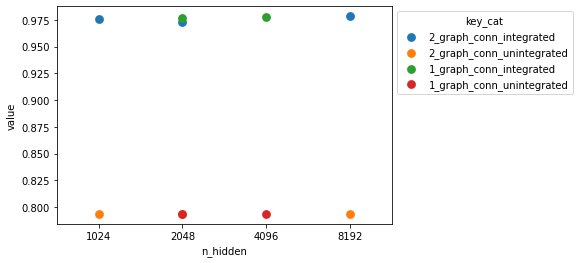

In [50]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

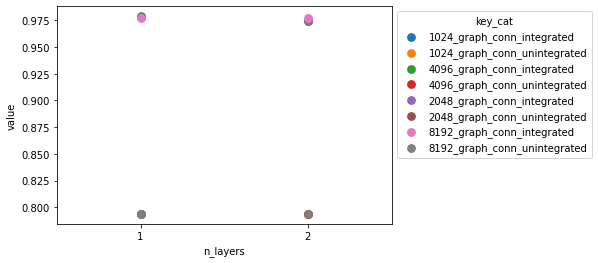

In [51]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

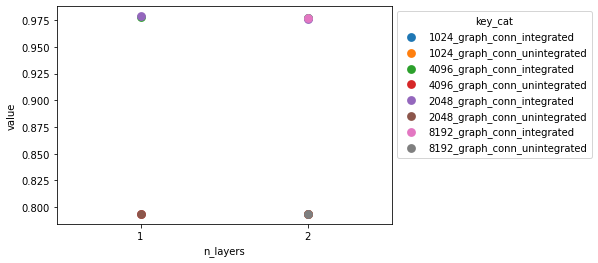

In [52]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

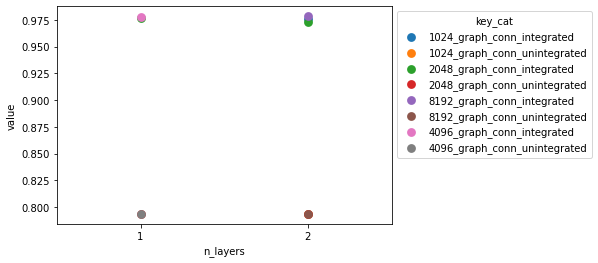

In [53]:
tmp = scib[[x in ['graph_conn_integrated', 'graph_conn_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Silhouette

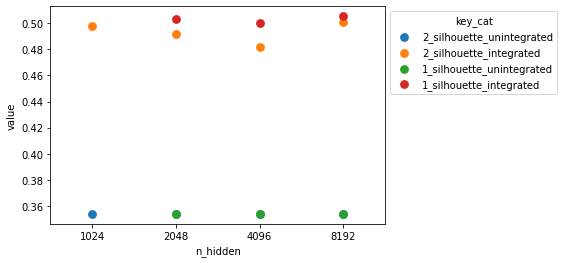

In [54]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

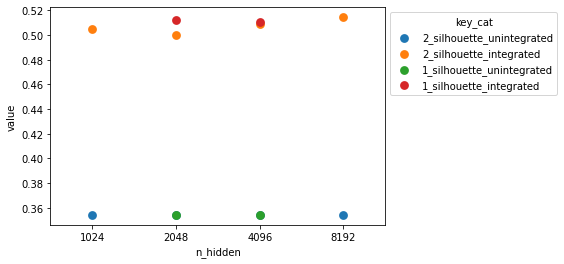

In [55]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

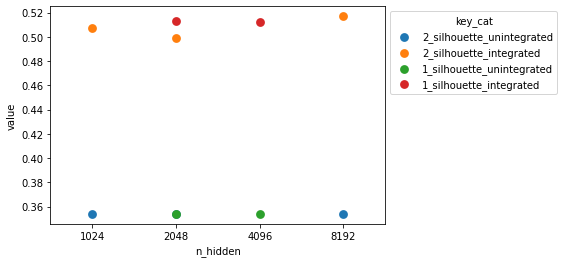

In [56]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

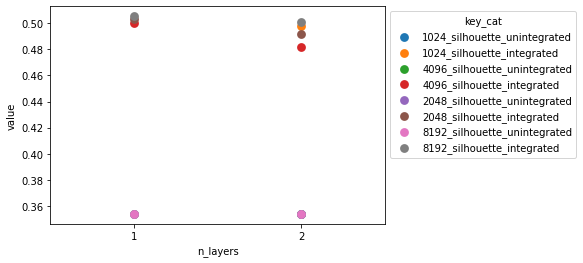

In [57]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

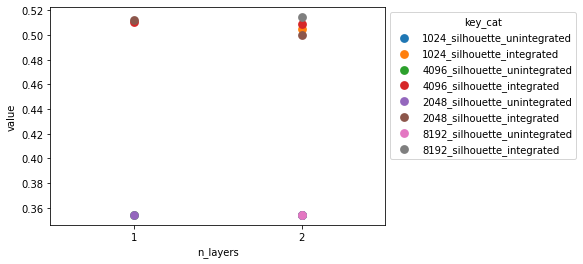

In [58]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

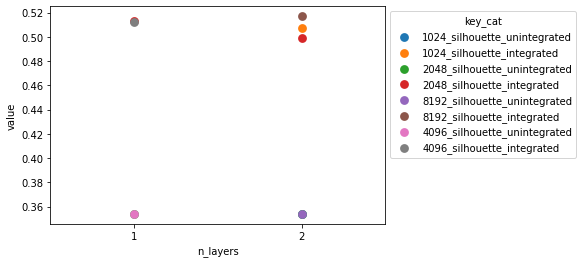

In [59]:
tmp = scib[[x in ['silhouette_integrated', 'silhouette_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## silhouette score for batch correction

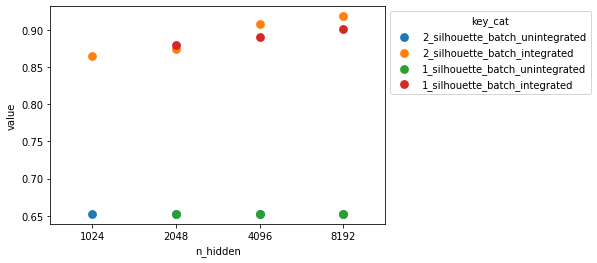

In [60]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

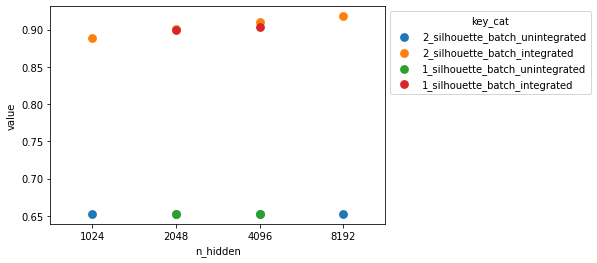

In [61]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

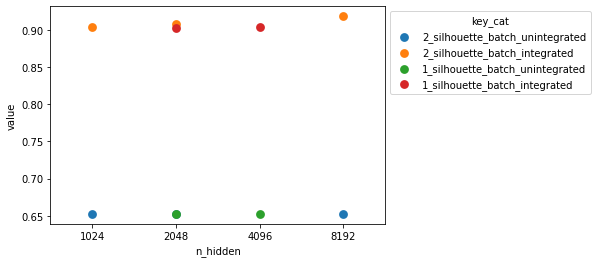

In [62]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

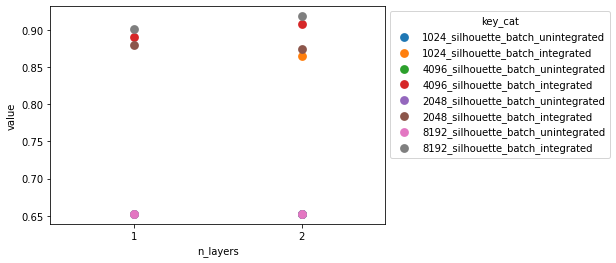

In [63]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

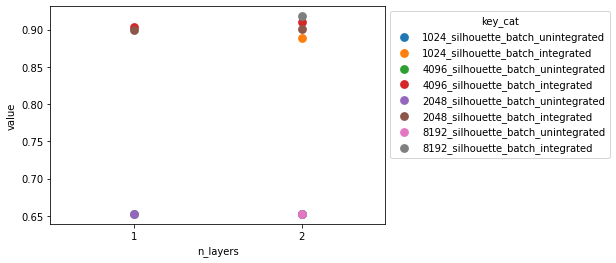

In [64]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

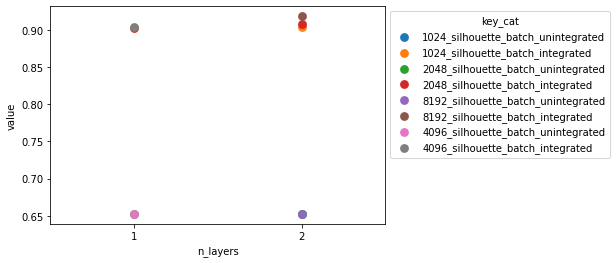

In [65]:
tmp = scib[[x in ['silhouette_batch_unintegrated', 'silhouette_batch_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Average Silhouette Width (ASW) for iso labels

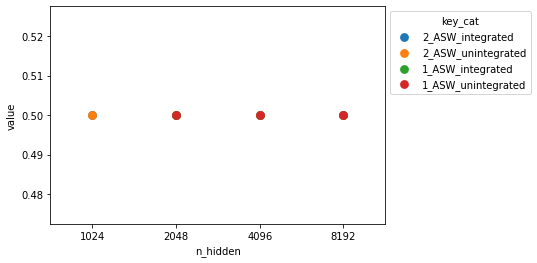

In [66]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

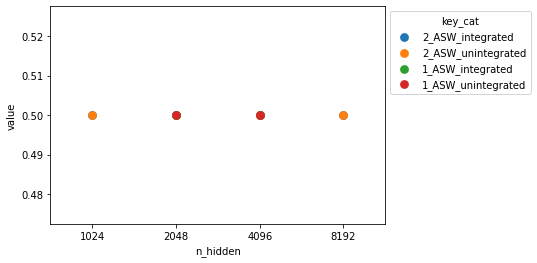

In [67]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

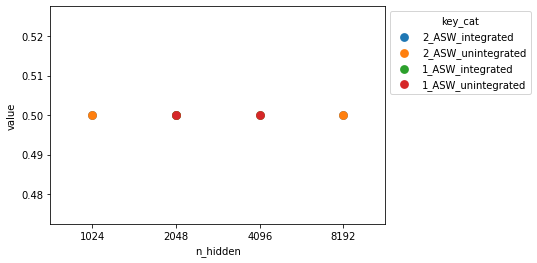

In [68]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

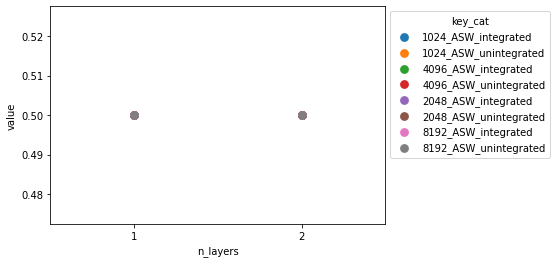

In [69]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

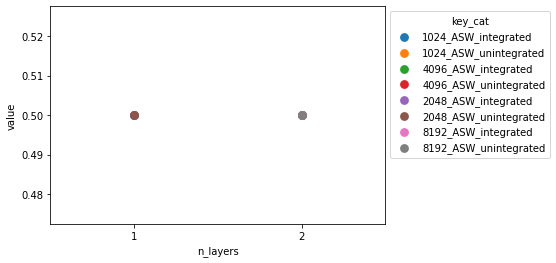

In [70]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

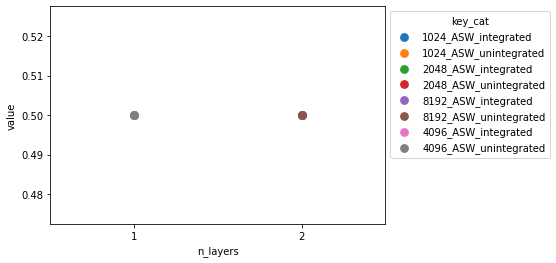

In [71]:
tmp = scib[[x in ['ASW_integrated', 'ASW_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## cLISI

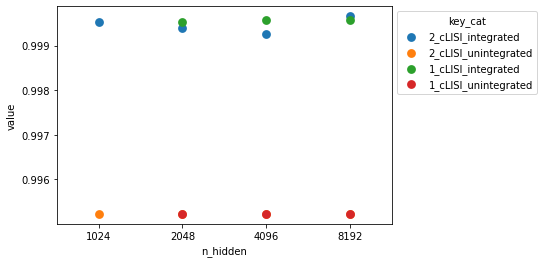

In [72]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

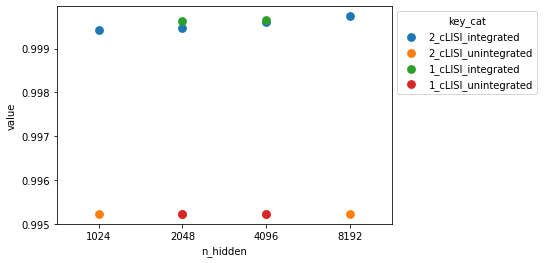

In [73]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

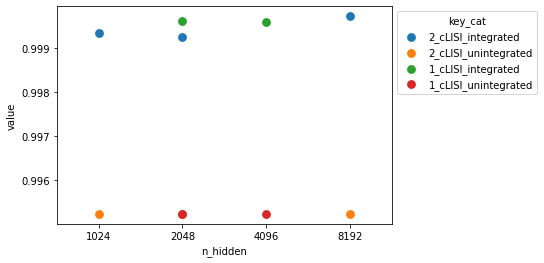

In [74]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

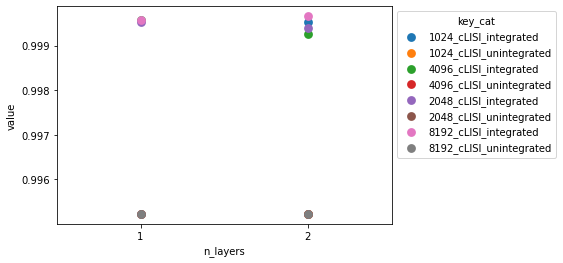

In [75]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

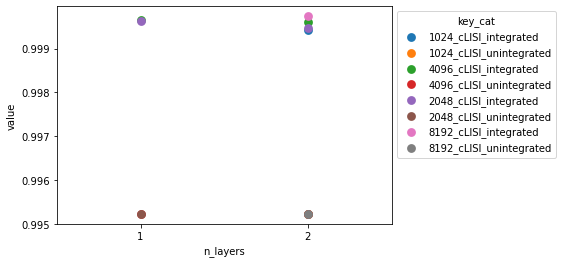

In [76]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

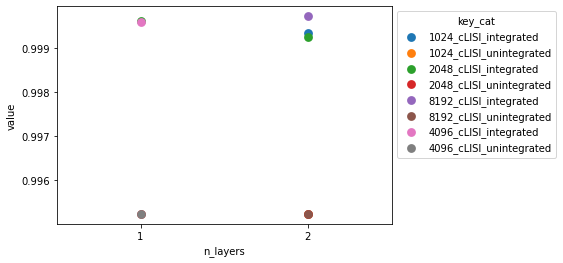

In [77]:
tmp = scib[[x in ['cLISI_integrated', 'cLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## iLISI

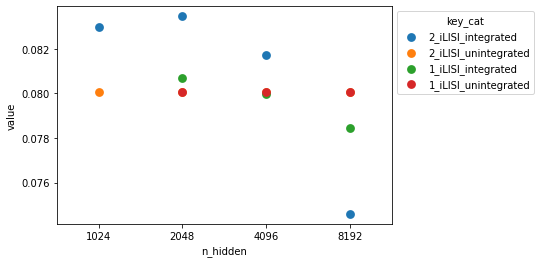

In [78]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

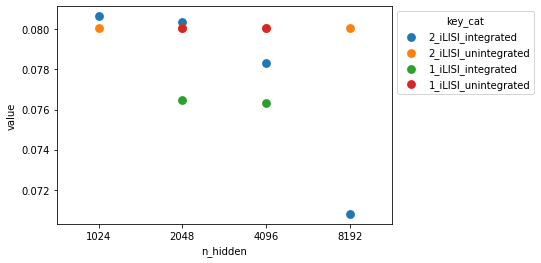

In [79]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

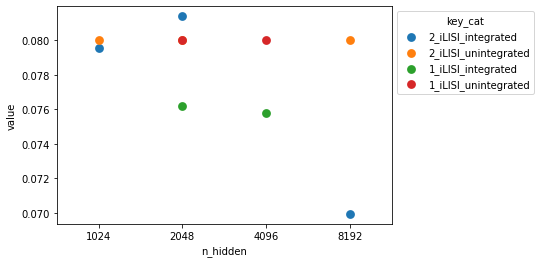

In [80]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

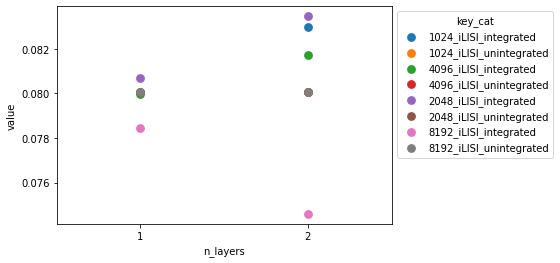

In [81]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

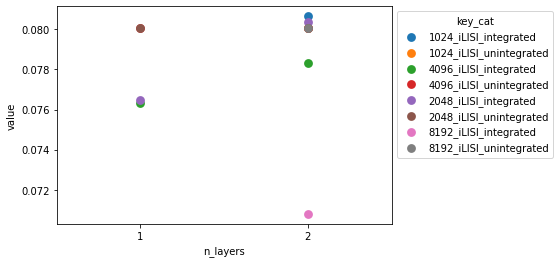

In [82]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

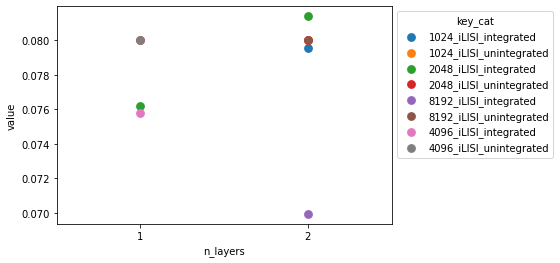

In [83]:
tmp = scib[[x in ['iLISI_integrated', 'iLISI_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## isolated Label F1

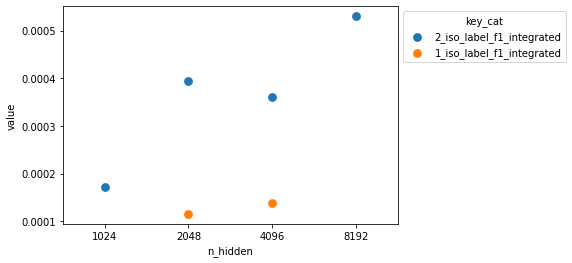

In [84]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

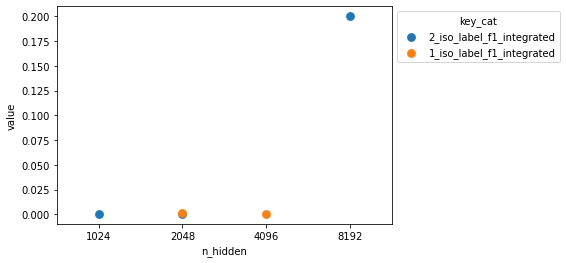

In [85]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

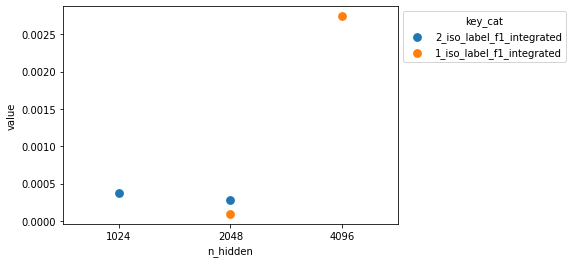

In [86]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

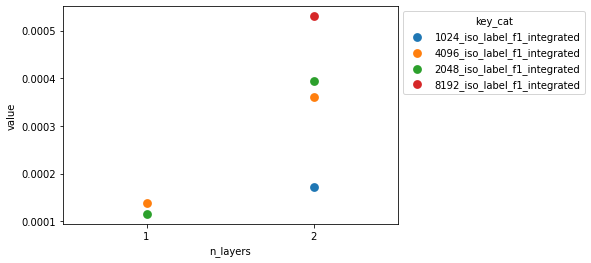

In [87]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

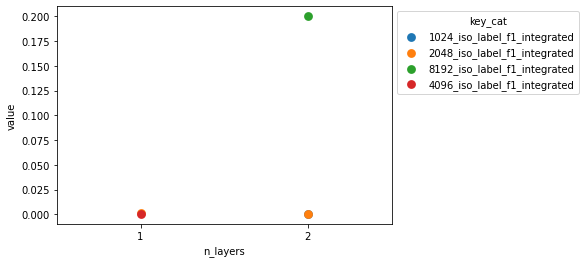

In [88]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

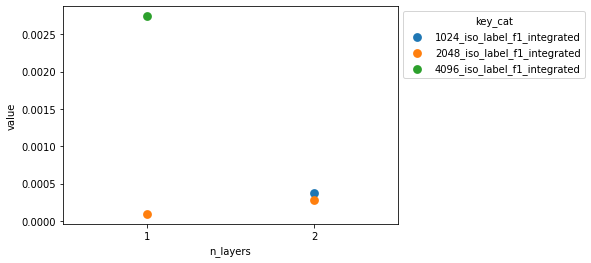

In [89]:
tmp = scib[[x in ['iso_label_f1_integrated', 'iso_label_f1_integrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Adjusted Rand Index

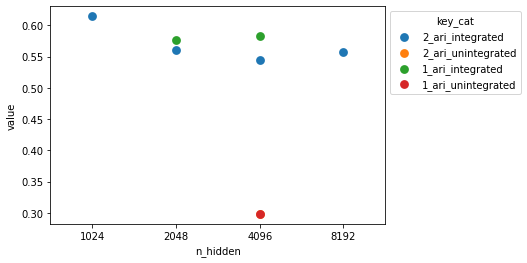

In [90]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

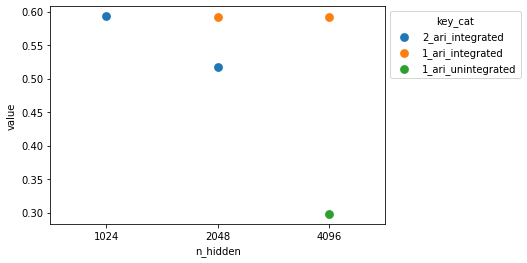

In [91]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

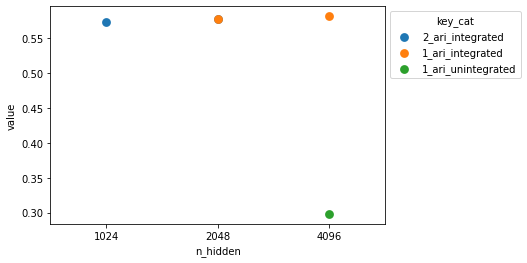

In [92]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

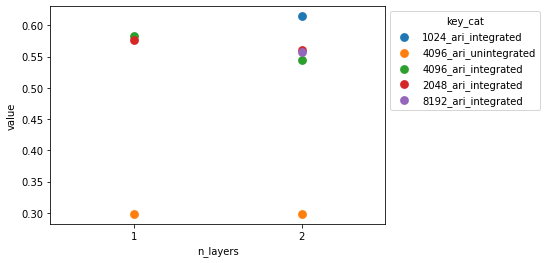

In [93]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

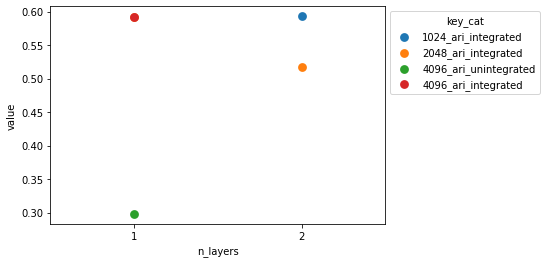

In [94]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

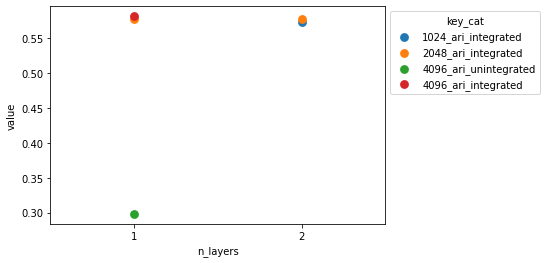

In [95]:
tmp = scib[[x in ['ari_integrated', 'ari_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

## Normalized mutual information

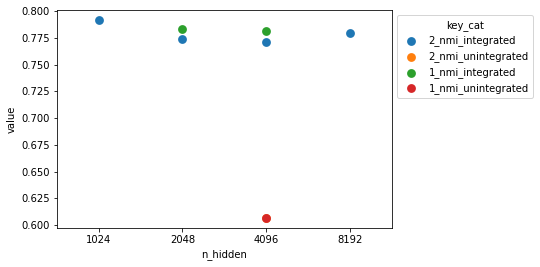

In [96]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

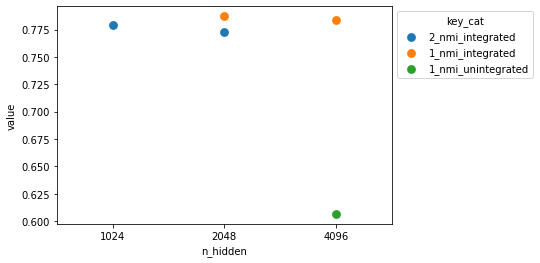

In [97]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

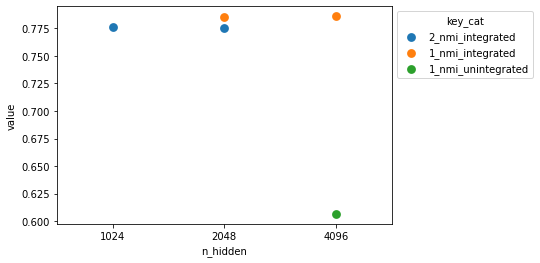

In [98]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_layers'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_hidden', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

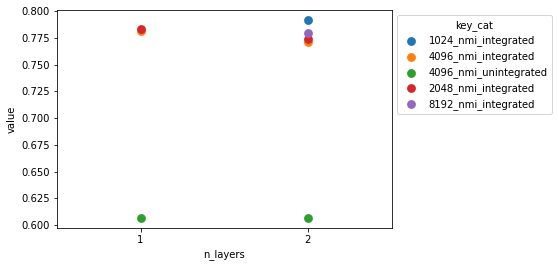

In [99]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='2k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

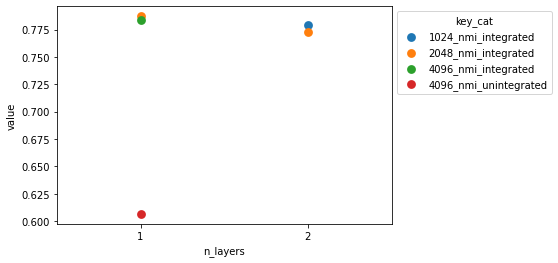

In [100]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='10k_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

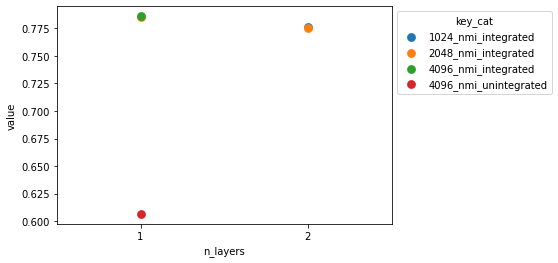

In [101]:
tmp = scib[[x in ['nmi_integrated', 'nmi_unintegrated'] for x in scib['metric']]]
tmp = tmp[tmp['n_cells']=='1M']
tmp['key_cat'] = tmp['n_hidden'].astype(str)+'_'+tmp['metric']
fig = sns.pointplot(tmp[tmp['n_genes']=='all_genes'], y='value', x='n_layers', hue='key_cat', linestyles="none")
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))